In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import scipy as sp
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline')

import glob
from nltk.stem.porter import *
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
import string


from nltk.corpus import stopwords
from collections import defaultdict
from gensim import corpora,models, similarities

from scipy import sparse
import numpy as np

In [3]:
corpus = corpora.MmCorpus('run1/corpus.mm')
dictionary = corpora.dictionary.Dictionary.load('run1/dictionary.dict')
tfidf = models.TfidfModel.load('run1/sraa.tfidf_model')

nontfidf = []
for i in range(len(dictionary)):
    k = tfidf[[(i,1)]]
    if len(k) == 0:
        nontfidf.append(i)
if len(nontfidf) > 0:
    print "ERROR: nontfidf: ", nontfidf


In [7]:
classes = [0,0,1,1]
names = ['realaviation','simaviation','realauto','simauto']
start = [0,4796,22241,63592]
end = [4796,22241,63592,73218]

sparseData = []
for data in corpus:
    sparseData.append(tfidf[data])
lens = [0,4796,22241,63592,73218]
for i in range(4):
    print lens[i+1] - lens[i]

numFeatures = len(dictionary.keys())
numData = len(sparseData)
numNodes = numData + numFeatures + 2

labels = np.zeros(numData)
A = sparse.lil_matrix((numNodes,numNodes))

# construct the labels
for i in range(4):
    if classes[i] == 1:
        labels[start[i]:end[i]] = np.ones(end[i]-start[i])
    else:
        labels[start[i]:end[i]] = np.zeros(end[i]-start[i])

# features: 0-numFeatures
# data: numFeature-(numFeature+numData)
# label: (numFeature+numData), (numFeature+numData+1)
# connect datas to features
for i in range(numData):
    for t in sparseData[i]:
        feature,weight = t[0],t[1]
        A[i+numFeatures,feature] = weight
        A[feature,i+numFeatures] = weight

# connect datas to labels
for i in xrange(numData):
    A[numData+numFeatures+labels[i],numData+i] = 1
    A[numData+i,numData+numFeatures+labels[i]] = 1

mask = []
for i in range(4):
    mask.append(np.zeros(numNodes,dtype=int))
    mask[i][start[i]+numFeatures:end[i]+numFeatures] = np.ones(end[i]-start[i])


4796
17445
41351
9626


In [8]:
#construct D
N = A.shape[0]
D = sparse.lil_matrix((N,N))
a = A.sum(axis=0)
for i in range(N):
    D[i,i] = a[0,i]
L = D-A
for i in range(numNodes):
    if D[i,i] >-0.0001 and D[i,i] < 0.0001:
        print i, D[i,i]
# generalized eigenvalue decomposition  Lv = tDv
vals, vecs = sparse.linalg.eigs(L, k=120, M=D)

c:\Anaconda\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:228: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


In [5]:
len(sparseData)

73218

In [132]:
baze = range(80)
plotVecs = vecs[:,baze]
data1 = plotVecs[mask[0]==1]
data2 = plotVecs[mask[2]==1]
data3 = plotVecs[mask[1]==1]
data4 = plotVecs[mask[3]==1]

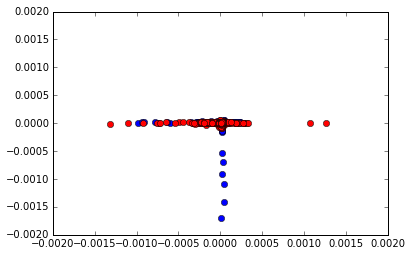

In [101]:

plt.plot(data3[:,0].real,data3[:,1].real,'bo')
plt.plot(data4[:,0].real,data4[:,1].real,'ro')
a = 0.002
plt.axis([-a,a,-a,a])
plt.savefig('run1/'+str(baze)+'.png')
plt.show()

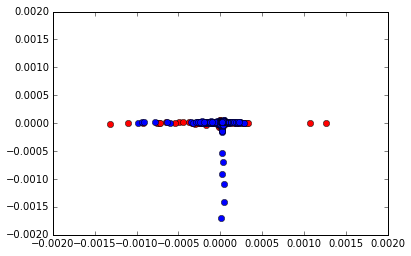

In [102]:
plt.plot(data4[:,0].real,data4[:,1].real,'ro')
plt.plot(data3[:,0].real,data3[:,1].real,'bo')

a = 0.002
plt.axis([-a,a,-a,a])
plt.savefig('run1/'+str(baze)+'_1.png')
plt.show()

In [26]:
print data3[:,0].min(),data3[:,0].max()
print data3[:,1].min(),data3[:,1].max()
print data4[:,0].min(),data4[:,0].max()
print data4[:,1].min(),data4[:,1].max()

(0.000881667612694+0j) (0.000881667612694+0j)
(-1.39783024357e-05+0j) (0.0997192078482+0j)
(0.000881667612694+0j) (0.000881667612694+0j)
(-2.36400780875e-05+0j) (0.0997134969222+0j)


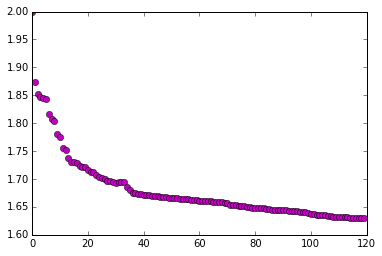

In [109]:
plt.plot(range(len(vals)),vals,'mo')

plt.savefig('run1/eigenValues.png')
plt.show()

In [133]:
from sklearn import svm
X1 = pd.DataFrame(data3)
X2 = pd.DataFrame(data4)
X = pd.concat([X1,X2])
print X.shape

(27071, 80)


In [134]:
classLabel = np.ones(X.shape[0],dtype=int)
classLabel[:X1.shape[0]] = np.zeros(X1.shape[0],dtype=int)

In [135]:
clf = svm.LinearSVC()
clf.fit(X,classLabel)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='l2', multi_class='ovr', penalty='l2',
     random_state=None, tol=0.0001, verbose=0)

In [136]:
pred = clf.predict(X)

In [137]:
(pred == classLabel).sum()*1.0/len(pred)

0.64574637065494445

In [139]:
from gensim.models.ldamodel import LdaModel

In [140]:
ldaModel = LdaModel(corpus, num_topics=30, id2word = dictionary, passes=20)

In [142]:
# import pickle
# pickle.dump(ldaModel,open('ldaModel','w'))
# ldaModel2 = pickle.load(file('ldaModel'))
ldaModel.save('run1/lda.model')
ldaModel2 = LdaModel.load('run1/lda.model')

In [ ]:
# # later on, load trained model from file
# model =  models.LdaModel.load('lda.model')

# # print all topics
# model.show_topics(topics=200, topn=20)

# # print topic 28
# model.print_topic(109, topn=20)

# # another way
# for i in range(0, model.num_topics-1):
#     print model.print_topic(i)

# # and another way, only prints top words
# for t in range(0, model.num_topics-1):
#     print 'topic {}: '.format(t) + ', '.join([v[1] for v in model.show_topic(t, 20)])

In [143]:
sparseDataLda = []
for data in corpus:
    sparseDataLda.append(ldaModel[data])

In [1]:
sparseDataLda[0]

NameError: name 'sparseDataLda' is not defined

In [162]:
lens = [0,4796,22241,63592,73218]
for i in range(4):
    print lens[i+1] - lens[i]

numFeatures = ldaModel.num_topics
numData = len(sparseDataLda)

labels = np.zeros(numData)
sparseX = sparse.lil_matrix((numData,numFeatures))

# construct the labels
for i in range(4):
    if classes[i] == 1:
        labels[start[i]:end[i]] = np.ones(end[i]-start[i])
    else:
        labels[start[i]:end[i]] = np.zeros(end[i]-start[i])

minf,maxf = 30,0
for i in range(numData):
    for t in sparseDataLda[i]:
        feature,weight = t[0],t[1]
        sparseX[i,feature] = weight
        
mask = []
for i in range(4):
    mask.append(np.zeros(numData,dtype=int))
    mask[i][start[i]:end[i]] = np.ones(end[i]-start[i])


4796
17445
41351
9626


In [167]:
dataset = pd.DataFrame(sparseX.toarray())

In [175]:
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.000000,0.154106,0.043651,0.000000,0.000000,0.000000,0,0,0.043292,0.419101,...,0.000000,0,0.065743,0,0.000000,0,0,0,0.000000,0.000000
1,0.000000,0.062356,0.060258,0.024779,0.069846,0.000000,0,0,0.000000,0.000000,...,0.000000,0,0.128542,0,0.000000,0,0,0,0.000000,0.000000
2,0.000000,0.104969,0.000000,0.028123,0.419489,0.000000,0,0,0.000000,0.018879,...,0.000000,0,0.198660,0,0.000000,0,0,0,0.000000,0.220789
3,0.024706,0.088973,0.000000,0.026759,0.014372,0.012875,0,0,0.000000,0.442303,...,0.000000,0,0.028194,0,0.000000,0,0,0,0.000000,0.000000
4,0.000000,0.155977,0.000000,0.311462,0.000000,0.000000,0,0,0.000000,0.246376,...,0.101948,0,0.000000,0,0.081365,0,0,0,0.010438,0.000000


In [185]:
X1 = dataset[mask[0]==1]
X2 = dataset[mask[2]==1]
X3 = dataset[mask[1]==1]
X4 = dataset[mask[3]==1]

In [186]:
from sklearn import svm
X = pd.concat([X1,X2])
print X.shape

(46147, 30)


In [187]:
classLabel = np.ones(X.shape[0],dtype=int)
classLabel[:X1.shape[0]] = np.zeros(X1.shape[0],dtype=int)
clf = svm.LinearSVC()
clf.fit(X,classLabel)
pred = clf.predict(X)
(pred == classLabel).sum()*1.0/len(pred)

0.96662838321017619

In [188]:
clf2 = svm.SVC(kernel='rbf')
clf2.fit(X,classLabel)
pred2 = clf2.predict(X)
(pred2 == classLabel).sum()*1.0/len(pred)

0.96027910806769667